Counts of Contract Awarded Status:
1    106809
0     34572
Name: Contract_Awarded, dtype: int64
              Accuracy Precision  Recall F1-Score
Random Forest   96.74%    96.73%  96.74%   96.71%
KNN             89.31%    89.23%  89.31%   89.27%
SVM             84.89%    84.22%  84.89%   84.30%
Decision Tree   96.30%    96.31%  96.30%   96.30%


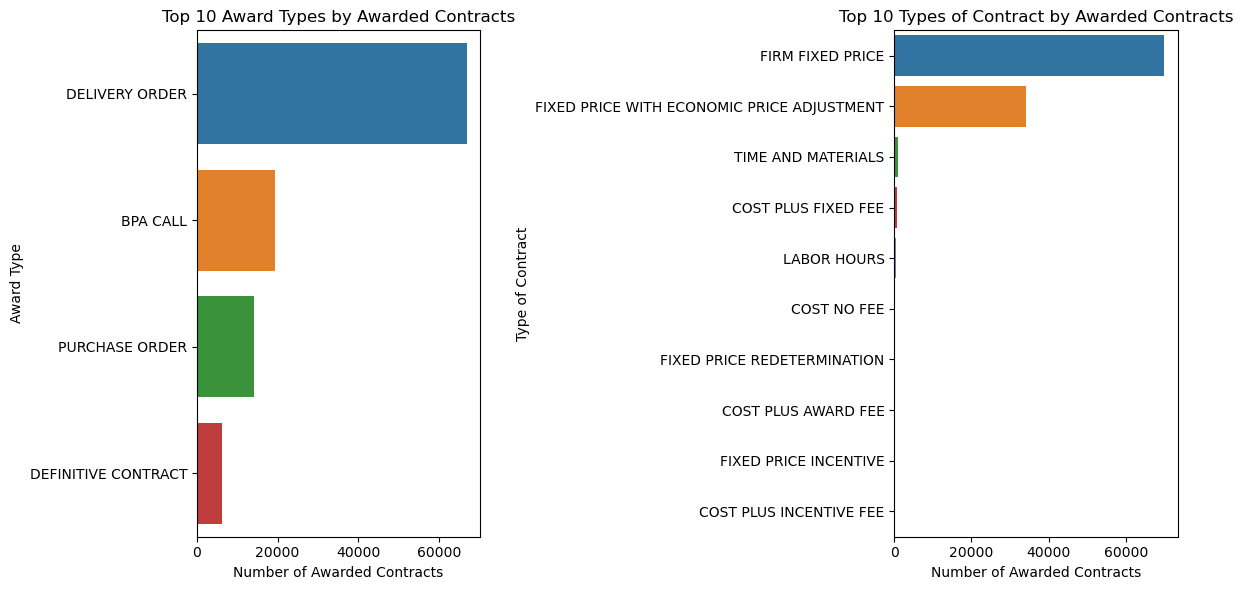

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

# Load the full dataset
data = pd.read_excel('Final COVID-19 Report.xlsx')

# Preprocessing and Feature Engineering
data['Period of Performance Start Date'] = pd.to_datetime(data['Period of Performance Start Date'], errors='coerce')
data['Completion Date'] = pd.to_datetime(data['Completion Date'], errors='coerce')
data['Contract Duration'] = (data['Completion Date'] - data['Period of Performance Start Date']).dt.days
data['Contract Duration'] = data['Contract Duration'].fillna(data['Contract Duration'].median())
data['Contract_Awarded'] = (data['Base and All Options Value (Total Contract Value)'] > 0).astype(int)

# Define features and target with 'Award Type' replacing 'Contracting Agency Name'
features = ['Award Type', 'Type of Contract', 'Product or Service Code', 'Action Obligation', 'Contract Duration']
target = 'Contract_Awarded'
X = data[features]
y = data[target]

# Count of 0's and 1's in the target variable
contract_awarded_counts = y.value_counts()
print("Counts of Contract Awarded Status:")
print(contract_awarded_counts)

# Export the preprocessed dataset
preprocessed_data = pd.concat([X, y], axis=1)
preprocessed_data.to_excel('preprocessed_data_contract_prediction.xlsx', index=False)

# Splitting the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Preprocessing steps
categorical_features = ['Award Type', 'Type of Contract', 'Product or Service Code']
numerical_features = ['Action Obligation', 'Contract Duration']

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Model definitions
models = {
    "Random Forest": RandomForestClassifier(n_estimators=100, max_depth=None, min_samples_split=2, min_samples_leaf=2),
    "KNN": KNeighborsClassifier(),
    "SVM": SVC(),
    "Decision Tree": DecisionTreeClassifier(),
    #"Logistic Regression": LogisticRegression()  # Added Logistic Regression
}

# Model comparison
model_performance = {}
for name, model in models.items():
    pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                               ('model', model)])
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred) * 100
    precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='weighted')
    precision, recall, f1 = precision * 100, recall * 100, f1 * 100

    model_performance[name] = {'Accuracy': f"{accuracy:.2f}%", 'Precision': f"{precision:.2f}%", 'Recall': f"{recall:.2f}%", 'F1-Score': f"{f1:.2f}%"}

model_performance_df = pd.DataFrame(model_performance).T
print(model_performance_df)

# Visualization

# Filter the data for awarded contracts
awarded_contracts = preprocessed_data[preprocessed_data['Contract_Awarded'] == 1]

# Count occurrences of 'Award Type' and 'Type of Contract' in awarded contracts
award_type_count = awarded_contracts['Award Type'].value_counts()
contract_type_count = awarded_contracts['Type of Contract'].value_counts()

# Preparing the data for plotting
top_award_types = award_type_count.head(10)
top_contract_types = contract_type_count.head(10)

# Plotting
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.barplot(x=top_award_types.values, y=top_award_types.index)
plt.title('Top 10 Award Types by Awarded Contracts')
plt.xlabel('Number of Awarded Contracts')
plt.ylabel('Award Type')

plt.subplot(1, 2, 2)
sns.barplot(x=top_contract_types.values, y=top_contract_types.index)
plt.title('Top 10 Types of Contract by Awarded Contracts')
plt.xlabel('Number of Awarded Contracts')
plt.ylabel('Type of Contract')

plt.tight_layout()
plt.show()
